## Stock Price Prediction using LSTM



In [1]:
import pandas as pd
import numpy as np
import torch
import joblib
import yfinance as yf
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

### 1. Data Acquisition with `yfinance`

- **Purpose**: `yfinance` is a popular open-source library that allows you to download historical market data from Yahoo! Finance directly into your Python environment.
- **Significance**: For time series forecasting, obtaining reliable historical data is the first crucial step. `yfinance` simplifies this by providing an easy interface to fetch stock prices, volumes, and other relevant metrics for a given ticker symbol over a specified period.
- **Key Function**: `yf.download()`: This function is used to fetch the data. You specify the stock ticker (e.g., "RELIANCE.NS"), the period (e.g., "9y" for 9 years), and the interval (e.g., "1d" for daily data). It returns a Pandas DataFrame.

In [2]:
# Gathering DataSet
ticker = "RELIANCE.NS"

# download last 9 years
df = yf.download(ticker, period="9y", interval="1d")

# save to CSV
df.to_csv("reliance.csv")

/tmp/ipython-input-471452597.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, period="9y", interval="1d")
[*********************100%***********************]  1 of 1 completed


### 2. Data Handling and Preprocessing with `pandas` and `numpy`

- **Purpose**: `pandas` is a fundamental library for data manipulation and analysis in Python. `numpy` provides support for large, multi-dimensional arrays and matrices, along with a collection of mathematical functions to operate on these arrays.
- **Significance**: Raw stock data often requires cleaning, transformation, and organization before it can be fed into a machine learning model. `pandas` DataFrames are ideal for this, allowing easy handling of time-series data.
- **Key Functions/Concepts**:
    - **`pd.read_csv()`**: Used to load data from a CSV file into a DataFrame.
    - **DataFrame Operations**: Renaming columns (`df.rename()`), converting data types (`df['Date'] = pd.to_datetime()`, `df[cols].astype(float)`), sorting data (`df.sort_values()`), and indexing (`df.iloc[]`, `df.head()`) are essential for structuring and inspecting the data.
    - **`numpy` arrays**: Internally, machine learning models often work with `numpy` arrays. Data from DataFrames is frequently converted to `numpy` arrays for processing by libraries like `scikit-learn` or `PyTorch`.

In [3]:
df = pd.read_csv("reliance.csv")

# remove yahoo-style header rows
df = df.iloc[2:].copy()

# rename first column
df.rename(columns={'Price':'Date'}, inplace=True)

# convert types
df['Date'] = pd.to_datetime(df['Date'])

cols = ['Open','High','Low','Close','Volume']
df[cols] = df[cols].astype(float)

df = df.sort_values('Date').reset_index(drop=True)

df.head()

,Date,Close,High,Low,Open,Volume
0,2017-02-16,233.914429,234.341722,230.638537,230.638537,19655195.0
1,2017-02-17,235.667435,236.259081,231.931381,233.695335,14847356.0
2,2017-02-20,235.645523,236.401507,233.695335,234.582775,11650581.0
3,2017-02-21,238.450317,239.052905,235.130587,235.601704,14186476.0
4,2017-02-22,264.591766,265.501118,239.282979,239.502111,127323130.0


In [4]:
split_idx = int(len(df)*7/9)

train_df = df.iloc[:split_idx]
test_df  = df.iloc[split_idx:]

print("Train:", len(train_df))
print("Test :", len(test_df))

Train: 1729
Test : 495


### 3. Feature Scaling with `sklearn.preprocessing.MinMaxScaler`

- **Purpose**: `MinMaxScaler` is a preprocessing technique that scales and translates each feature individually such that it is in the given range, typically between 0 and 1.
- **Significance**: Neural networks, especially those with gradient-based optimization algorithms (like LSTMs), perform better and converge faster when input features are on a similar scale. Large differences in feature ranges can lead to certain features dominating the learning process. Scaling prevents this and helps the model learn more effectively.
- **Key Functions**:
    - **`scaler.fit_transform()`**: Computes the minimum and maximum values of the training data and then scales the training data.
    - **`scaler.transform()`**: Scales new data (e.g., test data) using the min and max values learned from the training data. This prevents data leakage from the test set.
    - **`scaler.inverse_transform()`**: Converts scaled data back to its original range, which is crucial for interpreting predictions in their original units.

In [5]:
features = ['Open','High','Low','Close','Volume']

scaler = MinMaxScaler()

train_scaled = scaler.fit_transform(train_df[features])
test_scaled  = scaler.transform(test_df[features])

In [6]:
SEQ_LEN = 20
TARGET_COL = 3   # Close price index

def create_sequences(data):
    X, y = [], []
    for i in range(len(data)-SEQ_LEN):
        X.append(data[i:i+SEQ_LEN])
        y.append(data[i+SEQ_LEN, TARGET_COL])
    return np.array(X), np.array(y)

# training sequences
X_train, y_train = create_sequences(train_scaled)

# include last train window for test context
combined = np.vstack([train_scaled[-SEQ_LEN:], test_scaled])
X_test, y_test = create_sequences(combined)

print(X_train.shape, X_test.shape)

(1709, 20, 5) (495, 20, 5)


In [7]:
class StockDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [8]:
train_loader = DataLoader(StockDataset(X_train,y_train), batch_size=32, shuffle=False)
test_loader  = DataLoader(StockDataset(X_test,y_test), batch_size=32, shuffle=False)

### 4. LSTM Model Architecture with `torch.nn`

- **Purpose**: An LSTM (Long Short-Term Memory) is a type of Recurrent Neural Network (RNN) specifically designed to remember patterns over long sequences and mitigate the vanishing gradient problem inherent in traditional RNNs.
- **Significance**: LSTMs are well-suited for time series prediction tasks like stock forecasting because they can capture complex temporal dependencies and trends in the data. The `torch.nn` module provides all the building blocks for creating neural networks in PyTorch.
- **Key Components**:
    - **`nn.LSTM`**: This is the core LSTM layer. It takes an input sequence and outputs a hidden state and cell state for each time step. The `hidden_size` determines the number of memory units, and `num_layers` stacks multiple LSTM layers.
    - **`nn.Linear`**: A fully connected layer that transforms the output of the LSTM into the desired prediction (e.g., a single value for the next day's close price).
    - **`nn.Module`**: The base class for all neural network modules in PyTorch. Custom models inherit from this to define their layers and forward pass logic.

In [9]:
class LSTMModel(nn.Module):

    def __init__(self, input_size=5, hidden_size=64, num_layers=2):
        super().__init__()

        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True
        )

        self.fc = nn.Linear(hidden_size,1)

    def forward(self,x):
        out,_ = self.lstm(x)
        out = out[:,-1,:]
        out = self.fc(out)
        return out.squeeze()

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = LSTMModel().to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

### 6. Model Training with `torch.optim` and `nn.MSELoss`

- **Purpose**: Training a neural network involves iteratively adjusting its parameters (weights and biases) to minimize a loss function.
- **Significance**:
    - **Loss Function (`nn.MSELoss`)**: Mean Squared Error (MSE) is a common loss function for regression tasks. It measures the average of the squares of the errors, meaning the average squared difference between the estimated values and the actual value. Minimizing MSE aims to make the model's predictions as close as possible to the true values.
    - **Optimizer (`torch.optim.Adam`)**: Optimizers are algorithms used to update the weights of the neural network based on the gradients computed during backpropagation. Adam (Adaptive Moment Estimation) is a popular and efficient optimizer that adapts the learning rate for each parameter during training, leading to faster convergence and often better performance than simpler optimizers like SGD.
    - **`model.train()` and `model.eval()`**: These methods set the model to training or evaluation mode, respectively. This is important because certain layers (like Dropout or BatchNorm) behave differently during training and inference.

In [11]:
EPOCHS = 25

for epoch in range(EPOCHS):

    model.train()
    total_loss = 0

    for Xb, yb in train_loader:

        Xb = Xb.to(device)
        yb = yb.to(device)

        optimizer.zero_grad()
        pred = model(Xb)
        loss = criterion(pred, yb)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1} Loss: {total_loss/len(train_loader):.6f}")

Epoch 1 Loss: 0.007559
Epoch 2 Loss: 0.043636
Epoch 3 Loss: 0.023273
Epoch 4 Loss: 0.008467
Epoch 5 Loss: 0.001682
Epoch 6 Loss: 0.000920
Epoch 7 Loss: 0.000822
Epoch 8 Loss: 0.000731
Epoch 9 Loss: 0.000690
Epoch 10 Loss: 0.000643
Epoch 11 Loss: 0.000615
Epoch 12 Loss: 0.000588
Epoch 13 Loss: 0.000567
Epoch 14 Loss: 0.000547
Epoch 15 Loss: 0.000531
Epoch 16 Loss: 0.000515
Epoch 17 Loss: 0.000501
Epoch 18 Loss: 0.000489
Epoch 19 Loss: 0.000478
Epoch 20 Loss: 0.000470
Epoch 21 Loss: 0.000465
Epoch 22 Loss: 0.000462
Epoch 23 Loss: 0.000463
Epoch 24 Loss: 0.000464
Epoch 25 Loss: 0.000467


### 6. LSTM Model Architecture with `torch.nn`

- **Purpose**: An LSTM (Long Short-Term Memory) is a type of Recurrent Neural Network (RNN) specifically designed to remember patterns over long sequences and mitigate the vanishing gradient problem inherent in traditional RNNs.
- **Significance**: LSTMs are well-suited for time series prediction tasks like stock forecasting because they can capture complex temporal dependencies and trends in the data. The `torch.nn` module provides all the building blocks for creating neural networks in PyTorch.
- **Key Components**:
    - **`nn.LSTM`**: This is the core LSTM layer. It takes an input sequence and outputs a hidden state and cell state for each time step. The `hidden_size` determines the number of memory units, and `num_layers` stacks multiple LSTM layers.
    - **`nn.Linear`**: A fully connected layer that transforms the output of the LSTM into the desired prediction (e.g., a single value for the next day's close price).
    - **`nn.Module`**: The base class for all neural network modules in PyTorch. Custom models inherit from this to define their layers and forward pass logic.

In [12]:
model.eval()

preds = []

with torch.no_grad():
    for Xb,_ in test_loader:
        Xb = Xb.to(device)
        preds.append(model(Xb).cpu().numpy())

preds = np.concatenate(preds)

In [13]:
dummy = np.zeros((len(preds),5))
dummy[:,TARGET_COL] = preds

pred_prices = scaler.inverse_transform(dummy)[:,TARGET_COL]

In [14]:
actual = test_df['Close'].values[:len(pred_prices)]

### 7. Visualizing Predictions: The Prediction Graph

- **Purpose**: The prediction graph visually compares the model's forecasted stock prices against the actual historical prices. It's a crucial step for qualitative assessment of the model's performance.
- **Significance**:
    - **Direct Comparison**: By plotting both the 'Actual' and 'Predicted' price series on the same graph, one can immediately see how closely the model's predictions track the real market movements.
    - **Trend Following**: A good model should capture the general trend of the stock price. The graph helps to determine if the LSTM is learning the overall direction of the price movements.
    - **Identifying Discrepancies**: It highlights periods where the model performs particularly well or poorly, showing where the predictions deviate significantly from the actual values. This can provide insights into model limitations or specific market conditions it struggles with.
- **Interpretation**: Ideally, the 'Predicted' line should closely mirror the 'Actual' line. Small deviations are expected, but large, consistent gaps or a complete lack of correlation would indicate a poor-performing model.

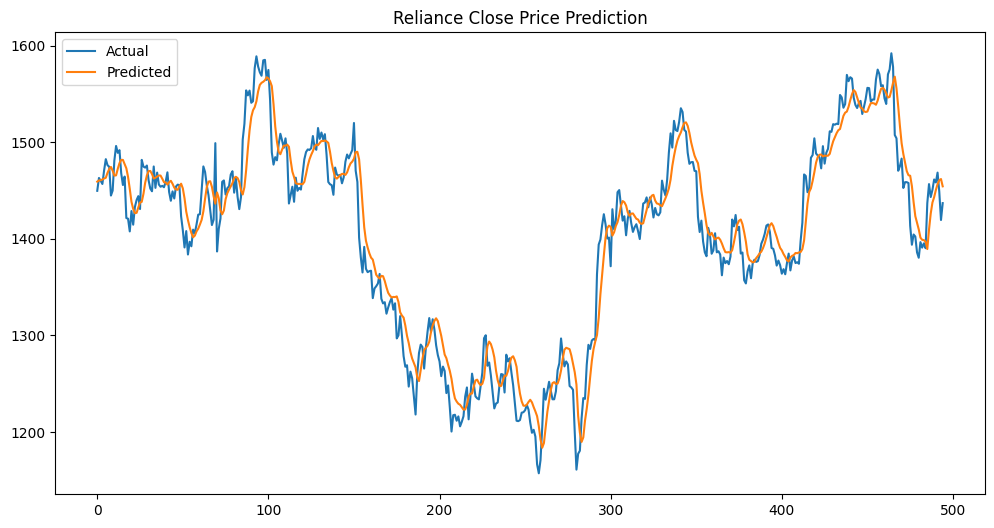

In [15]:
plt.figure(figsize=(12,6))
plt.plot(actual,label="Actual")
plt.plot(pred_prices,label="Predicted")
plt.legend()
plt.title("Reliance Close Price Prediction")
plt.show()

In [16]:
rmse = np.sqrt(mean_squared_error(actual, pred_prices))
r2 = r2_score(actual, pred_prices)

print(f"RMSE : {rmse:.2f}")
print(f"R² Score: {r2:.4f}")

RMSE : 26.37
R² Score: 0.9338
